In [1]:
import lbg_forecast.priors_gp_massfunc as gpmf
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import lbg_forecast.utils as utils


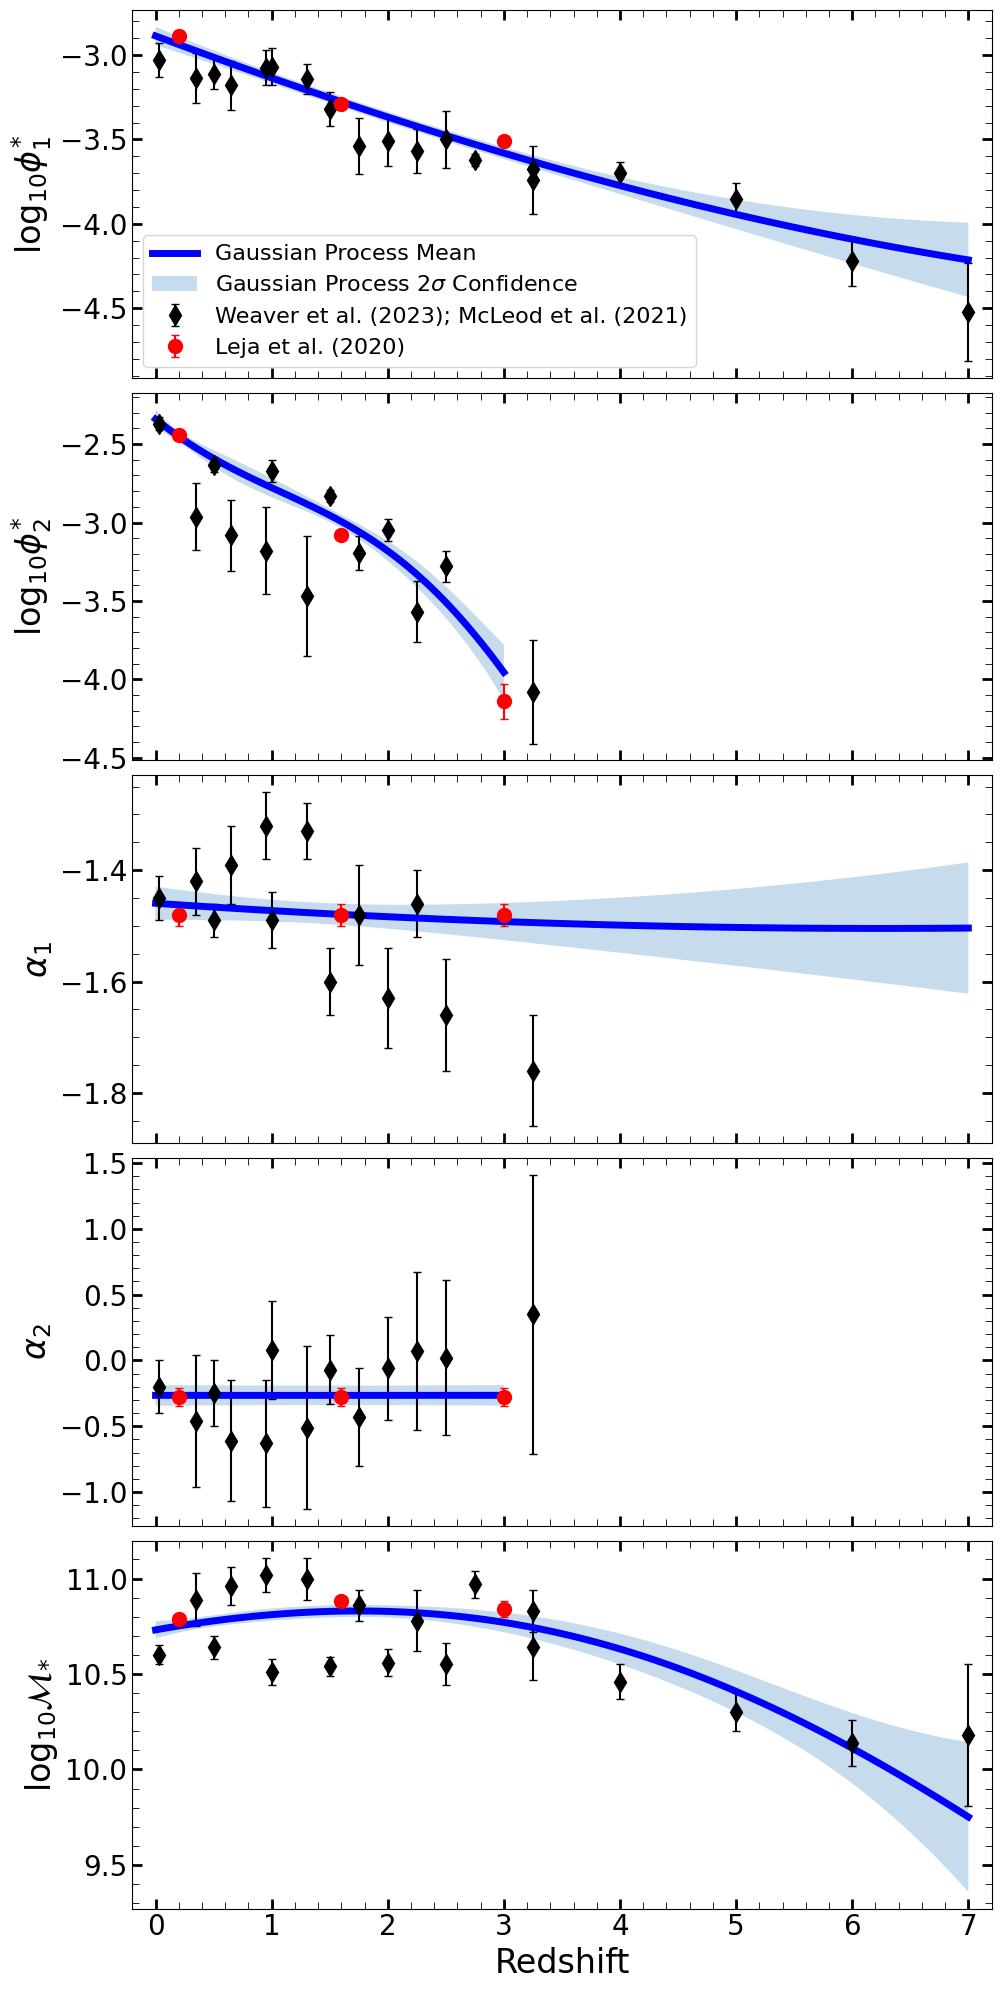

In [2]:
mass_function_prior = gpmf.MassFunctionPrior('.', mean=False)

mass_function_prior.plot_confidence()

1.0
LSST Number Density:  717.2534001795535


(0.0, 0.018)

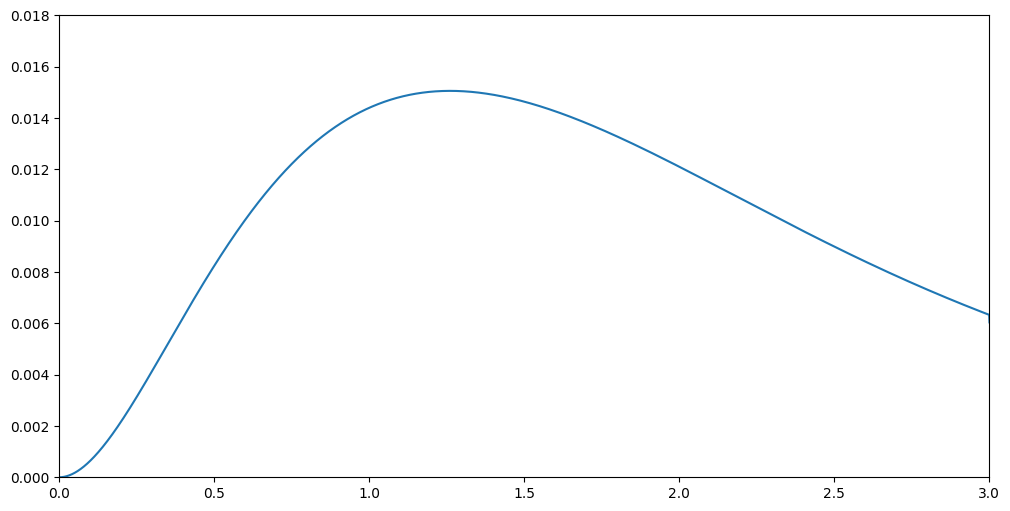

In [3]:
sparams = mass_function_prior.sample_prior_mean()

f, ax =plt.subplots(1, 1, figsize=(12, 6))

norm = mass_function_prior.n_tot(sparams)
dvdz = mass_function_prior.dvdz(mass_function_prior.z_grid, mass_function_prior.dz)

zs = mass_function_prior.z_grid
logms = mass_function_prior.logm_grid

i=0
n_z=[]
for z in zs:
    n_logm = mass_function_prior.normalised_mass_function(z, mass_function_prior.logm_grid, sparams, norm, dvdz[i])
    n_logm = np.trapz(n_logm, mass_function_prior.logm_grid)
    n_z.append(n_logm)
    i+=1

print(np.trapz(n_z, mass_function_prior.z_grid))

print("LSST Number Density: ", mass_function_prior.lsst_number_density(sparams))

n=[]
i=0
for z in zs:
    n.append(mass_function_prior.normalised_mass_function(z, 10, sparams, norm, dvdz[i]))

    i+=1

ax.plot(zs, n)
ax.set_xlim(0, 3)
ax.set_ylim(0, 0.018)

In [26]:
n_prior_samples = 300
nsamples=200000
zbins = np.linspace(0.0, 7.0, 100)
zarr=[]
#zs=[]
for i in range(n_prior_samples):
    zsamples, msamples = mass_function_prior.sample_logpdf(nsamples)
    z_histogram = np.histogram(zsamples, bins=zbins, density=True)
    #zs.append(zsamples)
    zarr.append(z_histogram[0])



Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sampling ... 
MCMC Sampling Complete.
Calculating Normalisation ... 
MCMC Sa

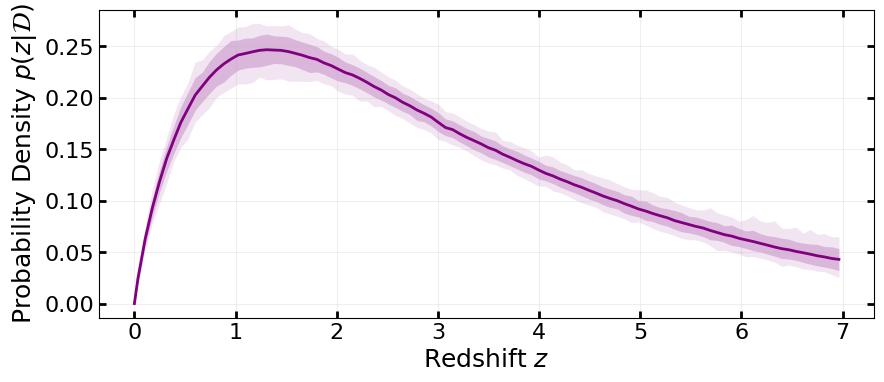

In [27]:
f, ax = plt.subplots(1, 1, figsize=(10, 4))

zs = np.vstack(np.array(zarr))
#np.save("zsamples_unnormalised.npy", zs)

#zs= np.load("zsamples_normalised.npy")

p1=90
percentile_zs1 = np.percentile(zs, [100-p1, 50, p1], axis=0)

p2=99
percentile_zs2 = np.percentile(zs, [100-p2, 50, p2], axis=0)

alpha=0.2
colour='purple'

zs_mean = np.concatenate((np.array([0]), np.mean(zs, axis=0)))
z_x = np.concatenate((np.array([0]), (zbins[:-1]+zbins[1:])/2))
upper1 = np.concatenate((np.array([0]), percentile_zs1[2, :]))
upper2 = np.concatenate((np.array([0]), percentile_zs2[2, :]))
lower1 = np.concatenate((np.array([0]), percentile_zs1[0, :]))
lower2 = np.concatenate((np.array([0]), percentile_zs2[0, :]))

ax.plot(z_x, zs_mean, lw=2, ms=3, color=colour)
ax.fill_between(z_x, lower1,  upper1, alpha=alpha, color=colour, lw=0)
ax.fill_between(z_x, lower2,  upper2, alpha=alpha/2, color=colour, lw=0)
ax.set_xlabel('Redshift $z$', fontsize=18)
ax.set_ylabel('Probability Density $p(z|\mathcal{D})$', fontsize=18)
ax.tick_params('x', labelsize=16, width=2, size=5, direction='in', top=True)
ax.tick_params('y', labelsize=16, width=2, size=5, direction='in', right=True)
ax.grid(visible=True, zorder=-1, alpha=0.2)


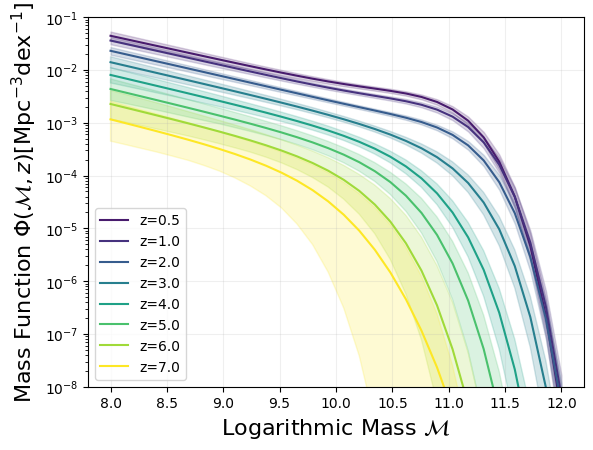

In [6]:
cmap = plt.get_cmap('viridis')
print(cmap)

redshift = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0])
masses = np.linspace(8, 12, 30)
nsamples = 5000
for z in redshift:
    mfunc_at_z = []
    for n in range(nsamples):
        mfunc = mass_function_prior.mass_function(z, masses, mass_function_prior.sample_prior())
        mfunc_at_z.append(mfunc)

    mfunc_at_z = np.vstack(np.array(mfunc_at_z))
    mfunc_at_z_mean = np.mean(mfunc_at_z, axis=0)
    mfunc_at_z_err = np.percentile(mfunc_at_z, [98, 50, 2], axis=0)

    #print(mfunc_at_z_mean, mfunc_at_z_err[0, :])

    plt.plot(masses, mfunc_at_z_mean, color=cmap(z/7), label="z="+str(z))
    plt.fill_between(masses, mfunc_at_z_err[0, :],  mfunc_at_z_err[2, :], color=cmap(z/7), alpha=0.2)
            
plt.ylim(1e-8, 1e-1)
plt.ylabel("Mass Function $\Phi(\mathcal{M}, z) [\mathrm{Mpc}^{-3}\mathrm{dex}^{-1}]$", fontsize=16)
plt.xlabel("Logarithmic Mass $\mathcal{M}$", fontsize=16)
#plt.tick_params('x', labelsize=18, width=2, size=5)
#plt.tick_params('y', labelsize=18, width=2, size=5)
plt.yscale('log')
plt.legend(loc="best")
plt.grid(visible=True, zorder=-1, alpha=0.2)